# Random Forest Classification

@author: Florian Beyer

Version: 0.3

Datum: 2020-05-07

Classification using Random Forest

Updates: 
- generating a report.txt with all outputs
- using all cores to improve processing time


The script is based on the classification script of Chris Holden:
SOURCE: http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

additional things added/integrated:
- independend validation
- exception handling for memory error during the prediction part
- shape files as input (Julien Rebetez https://github.com/terrai/rastercube/blob/master/rastercube/datasources/shputils.py)
- report.txt


### Section - Required packages

In [1]:
# packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import seaborn as sn

import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()


### Section - Input data

- This is the only section where you have to change something.

In [2]:

# define a number of trees that should be used (default = 500)
est = 300

# how many cores should be used?
# -1 -> all available cores
n_cores = -1

# the remote sensing image you want to classify
img_RS = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 9 Large\Inputs\Subset_Inputs\stacked_bands_output.tif"


# training and validation as shape files
training = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Training.shp"
validation = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Validation.shp"

# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'id'


# directory, where the classification image should be saved:
classification_image = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 9 Large\Ortho_classified.tif"

# directory, where the all meta results should be saved:
results_txt = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 9 Large\Ortho_results.txt"

In [3]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['fid', 'id', 'layer', 'path']


### Section - Data preparation

In [4]:
# prepare results text file:

print('Random Forest Classification', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('Training shape: {}'.format(training) , file=open(results_txt, "a"))
print('Vaildation shape: {}'.format(validation) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('Classification image: {}'.format(classification_image) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))


In [5]:
# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()


In [6]:
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))


Image extent: 19386 x 22125 (row x col)
Number of Bands: 6


In [7]:
# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()



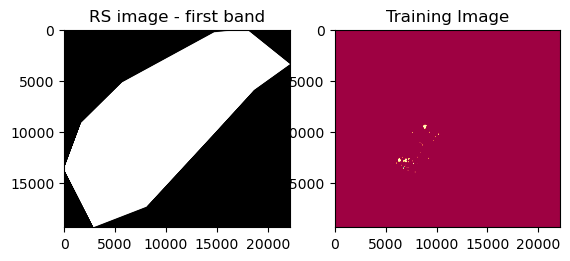

374409 training samples
training data include 2 classes: [1 2]
Our X matrix is sized: (374409, 6)
Our y array is sized: (374409,)


In [8]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()

# Number of training pixels:
n_samples = (roi > 0).sum()
print('{n} training samples'.format(n=n_samples))
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))

# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

### Section - Train Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)



# verbose = 2 -> prints out every tree progression
# rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=2, n_jobs=n_cores)



X = np.nan_to_num(X)
rf2 = rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.7s finished


### Section - RF Model Diagnostics

In [10]:
# With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

print('--------------------------------', file=open(results_txt, "a"))
print('TRAINING and RF Model Diagnostics:', file=open(results_txt, "a"))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100), file=open(results_txt, "a"))


# we can show the band importance:
bands = range(1,img_ds.RasterCount+1)

for b, imp in zip(bands, rf2.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    print('Band {b} importance: {imp}'.format(b=b, imp=imp), file=open(results_txt, "a"))

    
# Let's look at a crosstabulation to see the class confusion. 
# To do so, we will import the Pandas library for some help:
# Setup a dataframe -- just like R
# Exception Handling because of possible Memory Error

try:
    df = pd.DataFrame()
    df['truth'] = y
    df['predict'] = rf.predict(X)

except MemoryError:
    print('Crosstab not available ')

else:
    # Cross-tabulate predictions
    print(pd.crosstab(df['truth'], df['predict'], margins=True))
    print(pd.crosstab(df['truth'], df['predict'], margins=True), file=open(results_txt, "a"))

OOB prediction of accuracy is: 95.64967722463936%
Band 1 importance: 0.36820637083755725
Band 2 importance: 0.28651394047260753
Band 3 importance: 0.09406410638090885
Band 4 importance: 0.07350086621470112
Band 5 importance: 0.08763254938201925
Band 6 importance: 0.09008216671220602


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s


predict       1      2     All
truth                         
1        332578    191  332769
2           188  41452   41640
All      332766  41643  374409


[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished


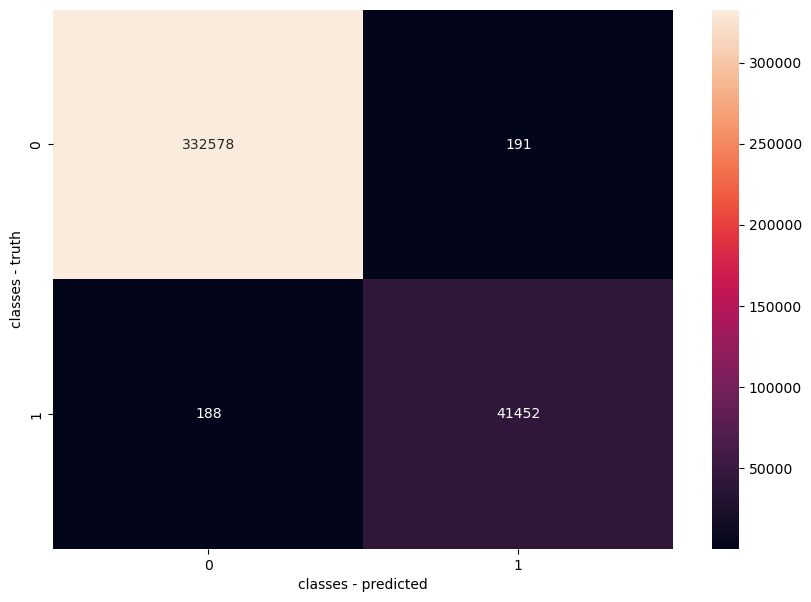

In [11]:
cm = confusion_matrix(y,rf.predict(X))
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

### Section - Prediction

In [12]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)


Reshaped from (19386, 22125, 6) to (428915250, 6)


In [16]:
# Now predict for each pixel
# first prediction will be tried on the entire image
# if not enough RAM, the dataset will be sliced
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round((len(img_as_array)/2)))
    print("Slices: ", slices)
    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
            for i in range(slices,len(img_as_array),slices):
                print('{} %, slices: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            slices = round(slices/2)
            print('Not enought RAM, new slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Class prediction was successful without slicing!')

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Slices:  214457625
Not enought RAM, new slices = 107228812


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Not enought RAM, new slices = 53614406
Not enought RAM, new slices = 26807203


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Not enought RAM, new slices = 13403602
Not enought RAM, new slices = 6701801
Not enought RAM, new slices = 3350900
Not enought RAM, new slices = 1675450
Not enought RAM, new slices = 837725


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Not enought RAM, new slices = 418862


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.09765612204275786 %, derzeit: 418862


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.19531224408551573 %, derzeit: 837724


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.2929683661282736 %, derzeit: 1256586


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.39062448817103146 %, derzeit: 1675448


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.4882806102137893 %, derzeit: 2094310


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.5859367322565472 %, derzeit: 2513172


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.683592854299305 %, derzeit: 2932034


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.7812489763420629 %, derzeit: 3350896


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.8789050983848208 %, derzeit: 3769758


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.9765612204275786 %, derzeit: 4188620


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.0742173424703365 %, derzeit: 4607482


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.1718734645130944 %, derzeit: 5026344


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.2695295865558522 %, derzeit: 5445206


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.36718570859861 %, derzeit: 5864068


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.464841830641368 %, derzeit: 6282930


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.5624979526841258 %, derzeit: 6701792


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.6601540747268837 %, derzeit: 7120654


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.7578101967696416 %, derzeit: 7539516


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.8554663188123994 %, derzeit: 7958378


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.9531224408551573 %, derzeit: 8377240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.050778562897915 %, derzeit: 8796102


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.148434684940673 %, derzeit: 9214964


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.246090806983431 %, derzeit: 9633826


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.3437469290261888 %, derzeit: 10052688


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.4414030510689466 %, derzeit: 10471550


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.5390591731117045 %, derzeit: 10890412


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.6367152951544623 %, derzeit: 11309274


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.73437141719722 %, derzeit: 11728136


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.832027539239978 %, derzeit: 12146998


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.929683661282736 %, derzeit: 12565860


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.027339783325494 %, derzeit: 12984722


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.1249959053682517 %, derzeit: 13403584


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.2226520274110095 %, derzeit: 13822446


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.3203081494537674 %, derzeit: 14241308


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.4179642714965253 %, derzeit: 14660170


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.515620393539283 %, derzeit: 15079032


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.613276515582041 %, derzeit: 15497894


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.710932637624799 %, derzeit: 15916756


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.8085887596675567 %, derzeit: 16335618


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.9062448817103146 %, derzeit: 16754480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.0039010037530725 %, derzeit: 17173342


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.10155712579583 %, derzeit: 17592204


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.199213247838588 %, derzeit: 18011066


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.296869369881346 %, derzeit: 18429928


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.394525491924104 %, derzeit: 18848790


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.492181613966862 %, derzeit: 19267652


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.58983773600962 %, derzeit: 19686514


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.6874938580523775 %, derzeit: 20105376


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.785149980095135 %, derzeit: 20524238


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.882806102137893 %, derzeit: 20943100


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.980462224180651 %, derzeit: 21361962


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.078118346223409 %, derzeit: 21780824


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.175774468266167 %, derzeit: 22199686


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.273430590308925 %, derzeit: 22618548


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.371086712351683 %, derzeit: 23037410


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.46874283439444 %, derzeit: 23456272


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.566398956437198 %, derzeit: 23875134


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.664055078479956 %, derzeit: 24293996


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.761711200522714 %, derzeit: 24712858


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.859367322565472 %, derzeit: 25131720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.95702344460823 %, derzeit: 25550582


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.054679566650988 %, derzeit: 25969444


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.1523356886937455 %, derzeit: 26388306


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.249991810736503 %, derzeit: 26807168


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.347647932779261 %, derzeit: 27226030


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.445304054822019 %, derzeit: 27644892


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.542960176864777 %, derzeit: 28063754


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.640616298907535 %, derzeit: 28482616


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.738272420950293 %, derzeit: 28901478


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.8359285429930505 %, derzeit: 29320340


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.933584665035808 %, derzeit: 29739202


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.031240787078566 %, derzeit: 30158064


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.128896909121324 %, derzeit: 30576926


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.226553031164082 %, derzeit: 30995788


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.32420915320684 %, derzeit: 31414650


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.421865275249598 %, derzeit: 31833512


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.519521397292356 %, derzeit: 32252374


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.6171775193351134 %, derzeit: 32671236


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.714833641377871 %, derzeit: 33090098


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.812489763420629 %, derzeit: 33508960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.910145885463387 %, derzeit: 33927822


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.007802007506145 %, derzeit: 34346684


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.105458129548902 %, derzeit: 34765546


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.20311425159166 %, derzeit: 35184408


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.300770373634418 %, derzeit: 35603270


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.398426495677176 %, derzeit: 36022132


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.496082617719933 %, derzeit: 36440994


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.593738739762692 %, derzeit: 36859856


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.691394861805449 %, derzeit: 37278718


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.789050983848208 %, derzeit: 37697580


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.886707105890965 %, derzeit: 38116442


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.984363227933724 %, derzeit: 38535304


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.08201934997648 %, derzeit: 38954166


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.17967547201924 %, derzeit: 39373028


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.277331594061996 %, derzeit: 39791890


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.374987716104755 %, derzeit: 40210752


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.472643838147512 %, derzeit: 40629614


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.57029996019027 %, derzeit: 41048476


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.667956082233028 %, derzeit: 41467338


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.765612204275786 %, derzeit: 41886200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.863268326318543 %, derzeit: 42305062


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.960924448361302 %, derzeit: 42723924


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.05858057040406 %, derzeit: 43142786


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.156236692446818 %, derzeit: 43561648


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.253892814489575 %, derzeit: 43980510


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.351548936532334 %, derzeit: 44399372


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.44920505857509 %, derzeit: 44818234


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.54686118061785 %, derzeit: 45237096


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.644517302660606 %, derzeit: 45655958


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.742173424703365 %, derzeit: 46074820


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.839829546746122 %, derzeit: 46493682


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.93748566878888 %, derzeit: 46912544


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.035141790831638 %, derzeit: 47331406


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.132797912874397 %, derzeit: 47750268


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.230454034917154 %, derzeit: 48169130


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.328110156959912 %, derzeit: 48587992


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.42576627900267 %, derzeit: 49006854


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.523422401045428 %, derzeit: 49425716


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.621078523088185 %, derzeit: 49844578


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.718734645130944 %, derzeit: 50263440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.8163907671737 %, derzeit: 50682302


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.91404688921646 %, derzeit: 51101164


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.011703011259216 %, derzeit: 51520026


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.109359133301975 %, derzeit: 51938888


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.207015255344732 %, derzeit: 52357750


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.304671377387491 %, derzeit: 52776612


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.402327499430248 %, derzeit: 53195474


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.499983621473007 %, derzeit: 53614336


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.597639743515764 %, derzeit: 54033198


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.695295865558522 %, derzeit: 54452060


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.79295198760128 %, derzeit: 54870922


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.890608109644038 %, derzeit: 55289784


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.988264231686795 %, derzeit: 55708646


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.085920353729554 %, derzeit: 56127508


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.18357647577231 %, derzeit: 56546370


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.28123259781507 %, derzeit: 56965232


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.378888719857827 %, derzeit: 57384094


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.476544841900585 %, derzeit: 57802956


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.574200963943342 %, derzeit: 58221818


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.671857085986101 %, derzeit: 58640680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.769513208028858 %, derzeit: 59059542


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.867169330071617 %, derzeit: 59478404


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.964825452114374 %, derzeit: 59897266


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.062481574157133 %, derzeit: 60316128


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.16013769619989 %, derzeit: 60734990


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.257793818242648 %, derzeit: 61153852


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.355449940285405 %, derzeit: 61572714


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.453106062328164 %, derzeit: 61991576


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.550762184370921 %, derzeit: 62410438


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.64841830641368 %, derzeit: 62829300


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.746074428456437 %, derzeit: 63248162


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.843730550499195 %, derzeit: 63667024


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.941386672541952 %, derzeit: 64085886


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.039042794584711 %, derzeit: 64504748


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.136698916627468 %, derzeit: 64923610


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.234355038670227 %, derzeit: 65342472


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.332011160712984 %, derzeit: 65761334


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.429667282755743 %, derzeit: 66180196


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.5273234047985 %, derzeit: 66599058


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.624979526841258 %, derzeit: 67017920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.722635648884015 %, derzeit: 67436782


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.820291770926774 %, derzeit: 67855644


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.917947892969531 %, derzeit: 68274506


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.01560401501229 %, derzeit: 68693368


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.113260137055047 %, derzeit: 69112230


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.210916259097804 %, derzeit: 69531092


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.308572381140564 %, derzeit: 69949954


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.40622850318332 %, derzeit: 70368816


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.50388462522608 %, derzeit: 70787678


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.601540747268835 %, derzeit: 71206540


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.699196869311596 %, derzeit: 71625402


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.796852991354353 %, derzeit: 72044264


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.89450911339711 %, derzeit: 72463126


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.992165235439867 %, derzeit: 72881988


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.089821357482627 %, derzeit: 73300850


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.187477479525384 %, derzeit: 73719712


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.28513360156814 %, derzeit: 74138574


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.382789723610898 %, derzeit: 74557436


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.48044584565366 %, derzeit: 74976298


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.578101967696416 %, derzeit: 75395160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.675758089739173 %, derzeit: 75814022


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.77341421178193 %, derzeit: 76232884


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.87107033382469 %, derzeit: 76651746


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.968726455867447 %, derzeit: 77070608


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.066382577910204 %, derzeit: 77489470


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.16403869995296 %, derzeit: 77908332


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.26169482199572 %, derzeit: 78327194


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.35935094403848 %, derzeit: 78746056


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.457007066081236 %, derzeit: 79164918


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.554663188123993 %, derzeit: 79583780


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.652319310166753 %, derzeit: 80002642


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.74997543220951 %, derzeit: 80421504


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.847631554252267 %, derzeit: 80840366


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.945287676295024 %, derzeit: 81259228


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.042943798337785 %, derzeit: 81678090


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.14059992038054 %, derzeit: 82096952


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.2382560424233 %, derzeit: 82515814


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.335912164466055 %, derzeit: 82934676


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.433568286508816 %, derzeit: 83353538


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.531224408551573 %, derzeit: 83772400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.62888053059433 %, derzeit: 84191262


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.726536652637087 %, derzeit: 84610124


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.824192774679847 %, derzeit: 85028986


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.921848896722604 %, derzeit: 85447848


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.01950501876536 %, derzeit: 85866710


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.11716114080812 %, derzeit: 86285572


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.21481726285088 %, derzeit: 86704434


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.312473384893636 %, derzeit: 87123296


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.410129506936393 %, derzeit: 87542158


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.50778562897915 %, derzeit: 87961020


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.60544175102191 %, derzeit: 88379882


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.703097873064667 %, derzeit: 88798744


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.800753995107424 %, derzeit: 89217606


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.89841011715018 %, derzeit: 89636468


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.996066239192942 %, derzeit: 90055330


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.0937223612357 %, derzeit: 90474192


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.191378483278456 %, derzeit: 90893054


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.289034605321213 %, derzeit: 91311916


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.386690727363973 %, derzeit: 91730778


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.48434684940673 %, derzeit: 92149640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.582002971449487 %, derzeit: 92568502


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.679659093492244 %, derzeit: 92987364


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.777315215535005 %, derzeit: 93406226


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.87497133757776 %, derzeit: 93825088


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.97262745962052 %, derzeit: 94243950


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.070283581663276 %, derzeit: 94662812


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.167939703706036 %, derzeit: 95081674


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.265595825748793 %, derzeit: 95500536


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.36325194779155 %, derzeit: 95919398


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.460908069834307 %, derzeit: 96338260


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.558564191877068 %, derzeit: 96757122


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.656220313919825 %, derzeit: 97175984


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.75387643596258 %, derzeit: 97594846


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.85153255800534 %, derzeit: 98013708


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.9491886800481 %, derzeit: 98432570


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.046844802090856 %, derzeit: 98851432


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.144500924133613 %, derzeit: 99270294


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.24215704617637 %, derzeit: 99689156


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.33981316821913 %, derzeit: 100108018


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.437469290261888 %, derzeit: 100526880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.535125412304644 %, derzeit: 100945742


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.6327815343474 %, derzeit: 101364604


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.730437656390162 %, derzeit: 101783466


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.82809377843292 %, derzeit: 102202328


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.925749900475676 %, derzeit: 102621190


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.023406022518433 %, derzeit: 103040052


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.121062144561193 %, derzeit: 103458914


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.21871826660395 %, derzeit: 103877776


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.316374388646707 %, derzeit: 104296638


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.414030510689464 %, derzeit: 104715500


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.511686632732225 %, derzeit: 105134362


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.609342754774982 %, derzeit: 105553224


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.70699887681774 %, derzeit: 105972086


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.804654998860496 %, derzeit: 106390948


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.902311120903256 %, derzeit: 106809810


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.999967242946013 %, derzeit: 107228672


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.09762336498877 %, derzeit: 107647534


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.195279487031527 %, derzeit: 108066396


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.292935609074288 %, derzeit: 108485258


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.390591731117045 %, derzeit: 108904120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.488247853159802 %, derzeit: 109322982


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.58590397520256 %, derzeit: 109741844


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.68356009724532 %, derzeit: 110160706


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.781216219288076 %, derzeit: 110579568


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.878872341330833 %, derzeit: 110998430


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.97652846337359 %, derzeit: 111417292


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.07418458541635 %, derzeit: 111836154


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.171840707459108 %, derzeit: 112255016


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.269496829501865 %, derzeit: 112673878


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.36715295154462 %, derzeit: 113092740


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.464809073587382 %, derzeit: 113511602


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.56246519563014 %, derzeit: 113930464


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.660121317672896 %, derzeit: 114349326


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.757777439715653 %, derzeit: 114768188


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.855433561758414 %, derzeit: 115187050


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.95308968380117 %, derzeit: 115605912


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.050745805843928 %, derzeit: 116024774


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.148401927886685 %, derzeit: 116443636


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.246058049929445 %, derzeit: 116862498


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.343714171972202 %, derzeit: 117281360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.44137029401496 %, derzeit: 117700222


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.539026416057716 %, derzeit: 118119084


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.636682538100477 %, derzeit: 118537946


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.734338660143234 %, derzeit: 118956808


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.83199478218599 %, derzeit: 119375670


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.929650904228748 %, derzeit: 119794532


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.027307026271508 %, derzeit: 120213394


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.124963148314265 %, derzeit: 120632256


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.222619270357022 %, derzeit: 121051118


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.32027539239978 %, derzeit: 121469980


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.41793151444254 %, derzeit: 121888842


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.515587636485296 %, derzeit: 122307704


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.613243758528053 %, derzeit: 122726566


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.71089988057081 %, derzeit: 123145428


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.80855600261357 %, derzeit: 123564290


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.906212124656328 %, derzeit: 123983152


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.003868246699085 %, derzeit: 124402014


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.101524368741842 %, derzeit: 124820876


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.199180490784602 %, derzeit: 125239738


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.29683661282736 %, derzeit: 125658600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.394492734870116 %, derzeit: 126077462


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.492148856912873 %, derzeit: 126496324


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.589804978955634 %, derzeit: 126915186


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.68746110099839 %, derzeit: 127334048


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.785117223041148 %, derzeit: 127752910


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.882773345083905 %, derzeit: 128171772


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.980429467126665 %, derzeit: 128590634


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.078085589169422 %, derzeit: 129009496


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.17574171121218 %, derzeit: 129428358


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.273397833254936 %, derzeit: 129847220


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.371053955297697 %, derzeit: 130266082


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.468710077340454 %, derzeit: 130684944


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.56636619938321 %, derzeit: 131103806


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.664022321425968 %, derzeit: 131522668


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.76167844346873 %, derzeit: 131941530


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.859334565511485 %, derzeit: 132360392


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.956990687554242 %, derzeit: 132779254


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.054646809597 %, derzeit: 133198116


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.15230293163976 %, derzeit: 133616978


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.249959053682517 %, derzeit: 134035840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.347615175725274 %, derzeit: 134454702


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.44527129776803 %, derzeit: 134873564


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.54292741981079 %, derzeit: 135292426


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.640583541853548 %, derzeit: 135711288


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.738239663896305 %, derzeit: 136130150


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.835895785939062 %, derzeit: 136549012


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.933551907981823 %, derzeit: 136967874


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.03120803002458 %, derzeit: 137386736


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.12886415206734 %, derzeit: 137805598


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.226520274110094 %, derzeit: 138224460


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.32417639615285 %, derzeit: 138643322


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.42183251819561 %, derzeit: 139062184


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.51948864023837 %, derzeit: 139481046


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.61714476228113 %, derzeit: 139899908


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.714800884323886 %, derzeit: 140318770


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.81245700636664 %, derzeit: 140737632


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.9101131284094 %, derzeit: 141156494


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.00776925045216 %, derzeit: 141575356


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.10542537249491 %, derzeit: 141994218


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.20308149453767 %, derzeit: 142413080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.300737616580435 %, derzeit: 142831942


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.39839373862319 %, derzeit: 143250804


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.49604986066595 %, derzeit: 143669666


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.593705982708705 %, derzeit: 144088528


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.69136210475146 %, derzeit: 144507390


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.78901822679422 %, derzeit: 144926252


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.886674348836976 %, derzeit: 145345114


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.98433047087973 %, derzeit: 145763976


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.0819865929225 %, derzeit: 146182838


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.179642714965254 %, derzeit: 146601700


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.27729883700801 %, derzeit: 147020562


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.37495495905077 %, derzeit: 147439424


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.472611081093525 %, derzeit: 147858286


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.57026720313628 %, derzeit: 148277148


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.66792332517904 %, derzeit: 148696010


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.765579447221796 %, derzeit: 149114872


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.86323556926456 %, derzeit: 149533734


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.96089169130732 %, derzeit: 149952596


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.058547813350074 %, derzeit: 150371458


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.15620393539283 %, derzeit: 150790320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.25386005743559 %, derzeit: 151209182


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.351516179478345 %, derzeit: 151628044


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.4491723015211 %, derzeit: 152046906


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.54682842356386 %, derzeit: 152465768


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.64448454560662 %, derzeit: 152884630


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.74214066764938 %, derzeit: 153303492


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.83979678969214 %, derzeit: 153722354


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.937452911734894 %, derzeit: 154141216


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.03510903377765 %, derzeit: 154560078


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.13276515582041 %, derzeit: 154978940


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.230421277863165 %, derzeit: 155397802


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.32807739990592 %, derzeit: 155816664


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.425733521948686 %, derzeit: 156235526


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.52338964399144 %, derzeit: 156654388


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.6210457660342 %, derzeit: 157073250


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.71870188807696 %, derzeit: 157492112


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.816358010119714 %, derzeit: 157910974


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.91401413216247 %, derzeit: 158329836


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.01167025420523 %, derzeit: 158748698


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.109326376247985 %, derzeit: 159167560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.20698249829075 %, derzeit: 159586422


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.304638620333506 %, derzeit: 160005284


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.40229474237626 %, derzeit: 160424146


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.49995086441902 %, derzeit: 160843008


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.59760698646178 %, derzeit: 161261870


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.695263108504534 %, derzeit: 161680732


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.79291923054729 %, derzeit: 162099594


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.89057535259005 %, derzeit: 162518456


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.98823147463281 %, derzeit: 162937318


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.08588759667557 %, derzeit: 163356180


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.183543718718326 %, derzeit: 163775042


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.28119984076108 %, derzeit: 164193904


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.37885596280384 %, derzeit: 164612766


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.4765120848466 %, derzeit: 165031628


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.574168206889354 %, derzeit: 165450490


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.67182432893211 %, derzeit: 165869352


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.769480450974875 %, derzeit: 166288214


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.86713657301763 %, derzeit: 166707076


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.96479269506039 %, derzeit: 167125938


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.062448817103146 %, derzeit: 167544800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.1601049391459 %, derzeit: 167963662


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.25776106118866 %, derzeit: 168382524


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.35541718323142 %, derzeit: 168801386


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.453073305274174 %, derzeit: 169220248


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.55072942731694 %, derzeit: 169639110


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.648385549359695 %, derzeit: 170057972


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.74604167140245 %, derzeit: 170476834


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.84369779344521 %, derzeit: 170895696


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.941353915487966 %, derzeit: 171314558


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.03901003753072 %, derzeit: 171733420


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.13666615957348 %, derzeit: 172152282


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.23432228161624 %, derzeit: 172571144


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.331978403659 %, derzeit: 172990006


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.42963452570176 %, derzeit: 173408868


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.527290647744515 %, derzeit: 173827730


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.62494676978727 %, derzeit: 174246592


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.72260289183003 %, derzeit: 174665454


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.820259013872786 %, derzeit: 175084316


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.91791513591554 %, derzeit: 175503178


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.0155712579583 %, derzeit: 175922040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.113227380001064 %, derzeit: 176340902


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.21088350204382 %, derzeit: 176759764


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.30853962408658 %, derzeit: 177178626


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.406195746129335 %, derzeit: 177597488


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.50385186817209 %, derzeit: 178016350


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.60150799021485 %, derzeit: 178435212


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.699164112257606 %, derzeit: 178854074


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.79682023430036 %, derzeit: 179272936


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.89447635634313 %, derzeit: 179691798


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.992132478385884 %, derzeit: 180110660


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.08978860042864 %, derzeit: 180529522


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.1874447224714 %, derzeit: 180948384


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.285100844514155 %, derzeit: 181367246


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.38275696655691 %, derzeit: 181786108


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.48041308859967 %, derzeit: 182204970


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.578069210642425 %, derzeit: 182623832


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.67572533268519 %, derzeit: 183042694


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.77338145472795 %, derzeit: 183461556


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.8710375767707 %, derzeit: 183880418


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.96869369881346 %, derzeit: 184299280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.06634982085622 %, derzeit: 184718142


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.164005942898974 %, derzeit: 185137004


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.26166206494173 %, derzeit: 185555866


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.35931818698449 %, derzeit: 185974728


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.45697430902725 %, derzeit: 186393590


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.55463043107001 %, derzeit: 186812452


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.652286553112766 %, derzeit: 187231314


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.74994267515552 %, derzeit: 187650176


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.84759879719828 %, derzeit: 188069038


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.94525491924104 %, derzeit: 188487900


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.042911041283794 %, derzeit: 188906762


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.14056716332655 %, derzeit: 189325624


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.238223285369315 %, derzeit: 189744486


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.33587940741207 %, derzeit: 190163348


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.43353552945483 %, derzeit: 190582210


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.531191651497586 %, derzeit: 191001072


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.62884777354034 %, derzeit: 191419934


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.7265038955831 %, derzeit: 191838796


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.82416001762586 %, derzeit: 192257658


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.921816139668614 %, derzeit: 192676520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.01947226171138 %, derzeit: 193095382


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.117128383754135 %, derzeit: 193514244


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.21478450579689 %, derzeit: 193933106


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.31244062783965 %, derzeit: 194351968


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.410096749882406 %, derzeit: 194770830


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.50775287192516 %, derzeit: 195189692


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.60540899396792 %, derzeit: 195608554


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.70306511601068 %, derzeit: 196027416


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.80072123805344 %, derzeit: 196446278


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.8983773600962 %, derzeit: 196865140


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.996033482138955 %, derzeit: 197284002


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.09368960418171 %, derzeit: 197702864


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.19134572622447 %, derzeit: 198121726


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.289001848267226 %, derzeit: 198540588


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.38665797030998 %, derzeit: 198959450


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.48431409235274 %, derzeit: 199378312


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.581970214395504 %, derzeit: 199797174


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.67962633643826 %, derzeit: 200216036


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.77728245848102 %, derzeit: 200634898


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.874938580523775 %, derzeit: 201053760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.97259470256653 %, derzeit: 201472622


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.07025082460929 %, derzeit: 201891484


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.167906946652046 %, derzeit: 202310346


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.2655630686948 %, derzeit: 202729208


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.36321919073757 %, derzeit: 203148070


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.460875312780324 %, derzeit: 203566932


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.55853143482308 %, derzeit: 203985794


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.65618755686584 %, derzeit: 204404656


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.753843678908595 %, derzeit: 204823518


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.85149980095135 %, derzeit: 205242380


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.94915592299411 %, derzeit: 205661242


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.046812045036866 %, derzeit: 206080104


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.14446816707963 %, derzeit: 206498966


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.24212428912239 %, derzeit: 206917828


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.339780411165144 %, derzeit: 207336690


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.4374365332079 %, derzeit: 207755552


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.53509265525066 %, derzeit: 208174414


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.632748777293415 %, derzeit: 208593276


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.73040489933617 %, derzeit: 209012138


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.82806102137893 %, derzeit: 209431000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.92571714342169 %, derzeit: 209849862


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.02337326546445 %, derzeit: 210268724


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.12102938750721 %, derzeit: 210687586


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.218685509549964 %, derzeit: 211106448


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.31634163159272 %, derzeit: 211525310


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.41399775363548 %, derzeit: 211944172


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.511653875678235 %, derzeit: 212363034


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.60930999772099 %, derzeit: 212781896


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.706966119763756 %, derzeit: 213200758


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.80462224180651 %, derzeit: 213619620


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.90227836384927 %, derzeit: 214038482


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.99993448589203 %, derzeit: 214457344


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.097590607934784 %, derzeit: 214876206


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.19524672997754 %, derzeit: 215295068


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.2929028520203 %, derzeit: 215713930


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.390558974063055 %, derzeit: 216132792


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.48821509610582 %, derzeit: 216551654


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.585871218148576 %, derzeit: 216970516


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.68352734019133 %, derzeit: 217389378


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.78118346223409 %, derzeit: 217808240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.87883958427685 %, derzeit: 218227102


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.976495706319604 %, derzeit: 218645964


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.07415182836236 %, derzeit: 219064826


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.17180795040512 %, derzeit: 219483688


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.26946407244788 %, derzeit: 219902550


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.36712019449064 %, derzeit: 220321412


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.464776316533396 %, derzeit: 220740274


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.56243243857615 %, derzeit: 221159136


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.66008856061891 %, derzeit: 221577998


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.75774468266167 %, derzeit: 221996860


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.85540080470442 %, derzeit: 222415722


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.95305692674718 %, derzeit: 222834584


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.050713048789945 %, derzeit: 223253446


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.1483691708327 %, derzeit: 223672308


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.24602529287546 %, derzeit: 224091170


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.343681414918215 %, derzeit: 224510032


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.44133753696097 %, derzeit: 224928894


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.53899365900373 %, derzeit: 225347756


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.636649781046486 %, derzeit: 225766618


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.73430590308924 %, derzeit: 226185480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.83196202513201 %, derzeit: 226604342


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.929618147174764 %, derzeit: 227023204


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.02727426921752 %, derzeit: 227442066


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.12493039126028 %, derzeit: 227860928


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.222586513303035 %, derzeit: 228279790


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.32024263534579 %, derzeit: 228698652


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.41789875738855 %, derzeit: 229117514


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.515554879431306 %, derzeit: 229536376


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.61321100147407 %, derzeit: 229955238


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.71086712351683 %, derzeit: 230374100


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.808523245559584 %, derzeit: 230792962


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.90617936760234 %, derzeit: 231211824


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.0038354896451 %, derzeit: 231630686


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.101491611687855 %, derzeit: 232049548


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.19914773373061 %, derzeit: 232468410


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.29680385577337 %, derzeit: 232887272


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.39445997781613 %, derzeit: 233306134


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.49211609985889 %, derzeit: 233724996


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.58977222190165 %, derzeit: 234143858


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.687428343944404 %, derzeit: 234562720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.78508446598716 %, derzeit: 234981582


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.88274058802992 %, derzeit: 235400444


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.980396710072675 %, derzeit: 235819306


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.07805283211543 %, derzeit: 236238168


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.175708954158196 %, derzeit: 236657030


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.27336507620095 %, derzeit: 237075892


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.37102119824371 %, derzeit: 237494754


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.46867732028647 %, derzeit: 237913616


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.566333442329224 %, derzeit: 238332478


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.66398956437198 %, derzeit: 238751340


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.76164568641474 %, derzeit: 239170202


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.859301808457495 %, derzeit: 239589064


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.95695793050026 %, derzeit: 240007926


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.054614052543016 %, derzeit: 240426788


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.15227017458577 %, derzeit: 240845650


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.24992629662853 %, derzeit: 241264512


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.34758241867129 %, derzeit: 241683374


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.445238540714044 %, derzeit: 242102236


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.5428946627568 %, derzeit: 242521098


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.64055078479956 %, derzeit: 242939960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.73820690684232 %, derzeit: 243358822


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.83586302888508 %, derzeit: 243777684


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.933519150927836 %, derzeit: 244196546


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.03117527297059 %, derzeit: 244615408


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.12883139501335 %, derzeit: 245034270


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.22648751705611 %, derzeit: 245453132


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.324143639098864 %, derzeit: 245871994


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.42179976114162 %, derzeit: 246290856


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.519455883184385 %, derzeit: 246709718


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.61711200522714 %, derzeit: 247128580


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.7147681272699 %, derzeit: 247547442


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.812424249312656 %, derzeit: 247966304


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.91008037135541 %, derzeit: 248385166


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.00773649339817 %, derzeit: 248804028


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.10539261544093 %, derzeit: 249222890


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.203048737483684 %, derzeit: 249641752


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.30070485952645 %, derzeit: 250060614


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.398360981569205 %, derzeit: 250479476


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.49601710361196 %, derzeit: 250898338


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.59367322565472 %, derzeit: 251317200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.691329347697476 %, derzeit: 251736062


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.78898546974023 %, derzeit: 252154924


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.88664159178299 %, derzeit: 252573786


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.98429771382575 %, derzeit: 252992648


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.08195383586851 %, derzeit: 253411510


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.17960995791127 %, derzeit: 253830372


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.277266079954025 %, derzeit: 254249234


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.37492220199678 %, derzeit: 254668096


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.47257832403954 %, derzeit: 255086958


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.570234446082296 %, derzeit: 255505820


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.66789056812505 %, derzeit: 255924682


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.76554669016781 %, derzeit: 256343544


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.863202812210574 %, derzeit: 256762406


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.96085893425333 %, derzeit: 257181268


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.05851505629609 %, derzeit: 257600130


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.156171178338845 %, derzeit: 258018992


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.2538273003816 %, derzeit: 258437854


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.35148342242436 %, derzeit: 258856716


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.449139544467116 %, derzeit: 259275578


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.54679566650987 %, derzeit: 259694440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.64445178855264 %, derzeit: 260113302


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.742107910595394 %, derzeit: 260532164


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.83976403263815 %, derzeit: 260951026


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.93742015468091 %, derzeit: 261369888


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.035076276723665 %, derzeit: 261788750


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.13273239876642 %, derzeit: 262207612


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.23038852080918 %, derzeit: 262626474


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.328044642851935 %, derzeit: 263045336


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.4257007648947 %, derzeit: 263464198


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.52335688693746 %, derzeit: 263883060


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.62101300898021 %, derzeit: 264301922


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.71866913102297 %, derzeit: 264720784


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.81632525306573 %, derzeit: 265139646


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.913981375108484 %, derzeit: 265558508


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.01163749715124 %, derzeit: 265977370


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.109293619194 %, derzeit: 266396232


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.20694974123676 %, derzeit: 266815094


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.30460586327952 %, derzeit: 267233956


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.402261985322276 %, derzeit: 267652818


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.49991810736503 %, derzeit: 268071680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.59757422940779 %, derzeit: 268490542


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.69523035145055 %, derzeit: 268909404


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.792886473493304 %, derzeit: 269328266


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.89054259553606 %, derzeit: 269747128


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.988198717578825 %, derzeit: 270165990


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.08585483962158 %, derzeit: 270584852


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.18351096166434 %, derzeit: 271003714


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.281167083707096 %, derzeit: 271422576


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.37882320574985 %, derzeit: 271841438


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.47647932779261 %, derzeit: 272260300


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.57413544983537 %, derzeit: 272679162


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.671791571878124 %, derzeit: 273098024


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.76944769392089 %, derzeit: 273516886


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.867103815963645 %, derzeit: 273935748


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.9647599380064 %, derzeit: 274354610


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.06241606004916 %, derzeit: 274773472


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.16007218209192 %, derzeit: 275192334


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.25772830413467 %, derzeit: 275611196


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.35538442617744 %, derzeit: 276030058


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.45304054822019 %, derzeit: 276448920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.55069667026295 %, derzeit: 276867782


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.6483527923057 %, derzeit: 277286644


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.74600891434847 %, derzeit: 277705506


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.84366503639122 %, derzeit: 278124368


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.94132115843398 %, derzeit: 278543230


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.03897728047674 %, derzeit: 278962092


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.1366334025195 %, derzeit: 279380954


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.23428952456226 %, derzeit: 279799816


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.331945646605 %, derzeit: 280218678


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.42960176864777 %, derzeit: 280637540


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.52725789069052 %, derzeit: 281056402


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.62491401273329 %, derzeit: 281475264


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.72257013477605 %, derzeit: 281894126


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.8202262568188 %, derzeit: 282312988


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.91788237886156 %, derzeit: 282731850


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.01553850090431 %, derzeit: 283150712


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.11319462294708 %, derzeit: 283569574


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.21085074498983 %, derzeit: 283988436


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.30850686703259 %, derzeit: 284407298


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.40616298907534 %, derzeit: 284826160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.5038191111181 %, derzeit: 285245022


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s


66.60147523316087 %, derzeit: 285663884


[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.69913135520362 %, derzeit: 286082746


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.79678747724638 %, derzeit: 286501608


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.89444359928913 %, derzeit: 286920470


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.9920997213319 %, derzeit: 287339332


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.08975584337465 %, derzeit: 287758194


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.18741196541741 %, derzeit: 288177056


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.28506808746017 %, derzeit: 288595918


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.38272420950292 %, derzeit: 289014780


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.48038033154569 %, derzeit: 289433642


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.57803645358844 %, derzeit: 289852504


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.6756925756312 %, derzeit: 290271366


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.77334869767395 %, derzeit: 290690228


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.87100481971672 %, derzeit: 291109090


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.96866094175947 %, derzeit: 291527952


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.06631706380223 %, derzeit: 291946814


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.163973185845 %, derzeit: 292365676


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.26162930788774 %, derzeit: 292784538


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.35928542993051 %, derzeit: 293203400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.45694155197326 %, derzeit: 293622262


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.55459767401602 %, derzeit: 294041124


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.65225379605877 %, derzeit: 294459986


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.74990991810154 %, derzeit: 294878848


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.8475660401443 %, derzeit: 295297710


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.94522216218705 %, derzeit: 295716572


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.04287828422981 %, derzeit: 296135434


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.14053440627256 %, derzeit: 296554296


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.23819052831533 %, derzeit: 296973158


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.33584665035808 %, derzeit: 297392020


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.43350277240084 %, derzeit: 297810882


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.53115889444359 %, derzeit: 298229744


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.62881501648636 %, derzeit: 298648606


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.72647113852912 %, derzeit: 299067468


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.82412726057187 %, derzeit: 299486330


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.92178338261463 %, derzeit: 299905192


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.01943950465738 %, derzeit: 300324054


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.11709562670015 %, derzeit: 300742916


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.2147517487429 %, derzeit: 301161778


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.31240787078566 %, derzeit: 301580640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.41006399282843 %, derzeit: 301999502


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.50772011487118 %, derzeit: 302418364


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.60537623691394 %, derzeit: 302837226


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.70303235895669 %, derzeit: 303256088


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.80068848099945 %, derzeit: 303674950


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.8983446030422 %, derzeit: 304093812


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.99600072508497 %, derzeit: 304512674


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.09365684712772 %, derzeit: 304931536


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.19131296917048 %, derzeit: 305350398


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.28896909121325 %, derzeit: 305769260


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.386625213256 %, derzeit: 306188122


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.48428133529876 %, derzeit: 306606984


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.58193745734151 %, derzeit: 307025846


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.67959357938427 %, derzeit: 307444708


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.77724970142702 %, derzeit: 307863570


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.87490582346979 %, derzeit: 308282432


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.97256194551255 %, derzeit: 308701294


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.0702180675553 %, derzeit: 309120156


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.16787418959807 %, derzeit: 309539018


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.26553031164082 %, derzeit: 309957880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.36318643368358 %, derzeit: 310376742


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.46084255572633 %, derzeit: 310795604


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.5584986777691 %, derzeit: 311214466


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.65615479981184 %, derzeit: 311633328


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.75381092185461 %, derzeit: 312052190


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.85146704389737 %, derzeit: 312471052


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.94912316594012 %, derzeit: 312889914


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.04677928798289 %, derzeit: 313308776


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.14443541002564 %, derzeit: 313727638


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.2420915320684 %, derzeit: 314146500


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.33974765411115 %, derzeit: 314565362


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.43740377615391 %, derzeit: 314984224


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.53505989819668 %, derzeit: 315403086


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.63271602023943 %, derzeit: 315821948


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.73037214228219 %, derzeit: 316240810


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.82802826432494 %, derzeit: 316659672


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.9256843863677 %, derzeit: 317078534


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.02334050841046 %, derzeit: 317497396


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.12099663045322 %, derzeit: 317916258


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.21865275249597 %, derzeit: 318335120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.31630887453873 %, derzeit: 318753982


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.4139649965815 %, derzeit: 319172844


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.51162111862425 %, derzeit: 319591706


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.60927724066701 %, derzeit: 320010568


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.70693336270976 %, derzeit: 320429430


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.80458948475253 %, derzeit: 320848292


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.90224560679528 %, derzeit: 321267154


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.99990172883804 %, derzeit: 321686016


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.0975578508808 %, derzeit: 322104878


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.19521397292355 %, derzeit: 322523740


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.29287009496632 %, derzeit: 322942602


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.39052621700907 %, derzeit: 323361464


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.48818233905183 %, derzeit: 323780326


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.58583846109458 %, derzeit: 324199188


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.68349458313735 %, derzeit: 324618050


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.7811507051801 %, derzeit: 325036912


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.87880682722286 %, derzeit: 325455774


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.97646294926562 %, derzeit: 325874636


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.07411907130837 %, derzeit: 326293498


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.17177519335114 %, derzeit: 326712360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.26943131539389 %, derzeit: 327131222


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.36708743743665 %, derzeit: 327550084


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.4647435594794 %, derzeit: 327968946


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.56239968152217 %, derzeit: 328387808


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.66005580356493 %, derzeit: 328806670


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.75771192560768 %, derzeit: 329225532


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.85536804765044 %, derzeit: 329644394


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.9530241696932 %, derzeit: 330063256


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.05068029173596 %, derzeit: 330482118


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.14833641377871 %, derzeit: 330900980


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.24599253582147 %, derzeit: 331319842


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.34364865786422 %, derzeit: 331738704


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.44130477990699 %, derzeit: 332157566


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.53896090194975 %, derzeit: 332576428


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.6366170239925 %, derzeit: 332995290


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.73427314603526 %, derzeit: 333414152


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.83192926807801 %, derzeit: 333833014


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.92958539012078 %, derzeit: 334251876


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.02724151216353 %, derzeit: 334670738


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.12489763420629 %, derzeit: 335089600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.22255375624906 %, derzeit: 335508462


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.3202098782918 %, derzeit: 335927324


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.41786600033457 %, derzeit: 336346186


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.51552212237732 %, derzeit: 336765048


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.61317824442008 %, derzeit: 337183910


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.71083436646283 %, derzeit: 337602772


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.8084904885056 %, derzeit: 338021634


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.90614661054835 %, derzeit: 338440496


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.00380273259111 %, derzeit: 338859358


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.10145885463388 %, derzeit: 339278220


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.19911497667663 %, derzeit: 339697082


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.29677109871939 %, derzeit: 340115944


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.39442722076214 %, derzeit: 340534806


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.4920833428049 %, derzeit: 340953668


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.58973946484765 %, derzeit: 341372530


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.68739558689042 %, derzeit: 341791392


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.78505170893318 %, derzeit: 342210254


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.88270783097593 %, derzeit: 342629116


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.9803639530187 %, derzeit: 343047978


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.07802007506145 %, derzeit: 343466840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.17567619710421 %, derzeit: 343885702


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.27333231914696 %, derzeit: 344304564


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.37098844118972 %, derzeit: 344723426


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.46864456323247 %, derzeit: 345142288


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.56630068527524 %, derzeit: 345561150


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.663956807318 %, derzeit: 345980012


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.76161292936075 %, derzeit: 346398874


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.85926905140352 %, derzeit: 346817736


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.95692517344627 %, derzeit: 347236598


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.05458129548903 %, derzeit: 347655460


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.15223741753178 %, derzeit: 348074322


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.24989353957454 %, derzeit: 348493184


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.34754966161731 %, derzeit: 348912046


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.44520578366006 %, derzeit: 349330908


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.54286190570282 %, derzeit: 349749770


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.64051802774557 %, derzeit: 350168632


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.73817414978834 %, derzeit: 350587494


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.83583027183109 %, derzeit: 351006356


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.93348639387385 %, derzeit: 351425218


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.0311425159166 %, derzeit: 351844080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.12879863795936 %, derzeit: 352262942


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.22645476000213 %, derzeit: 352681804


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.32411088204488 %, derzeit: 353100666


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.42176700408764 %, derzeit: 353519528


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.51942312613039 %, derzeit: 353938390


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.61707924817316 %, derzeit: 354357252


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.7147353702159 %, derzeit: 354776114


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.81239149225867 %, derzeit: 355194976


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.91004761430143 %, derzeit: 355613838


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.00770373634418 %, derzeit: 356032700


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.10535985838695 %, derzeit: 356451562


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.2030159804297 %, derzeit: 356870424


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.30067210247246 %, derzeit: 357289286


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.39832822451521 %, derzeit: 357708148


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.49598434655798 %, derzeit: 358127010


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.59364046860073 %, derzeit: 358545872


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.69129659064349 %, derzeit: 358964734


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.78895271268625 %, derzeit: 359383596


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.886608834729 %, derzeit: 359802458


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.98426495677177 %, derzeit: 360221320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.08192107881452 %, derzeit: 360640182


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.17957720085728 %, derzeit: 361059044


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.27723332290003 %, derzeit: 361477906


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.3748894449428 %, derzeit: 361896768


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.47254556698556 %, derzeit: 362315630


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.57020168902831 %, derzeit: 362734492


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.66785781107107 %, derzeit: 363153354


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.76551393311382 %, derzeit: 363572216


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.86317005515659 %, derzeit: 363991078


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.96082617719934 %, derzeit: 364409940


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.0584822992421 %, derzeit: 364828802


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.15613842128485 %, derzeit: 365247664


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.25379454332761 %, derzeit: 365666526


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.35145066537038 %, derzeit: 366085388


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.44910678741313 %, derzeit: 366504250


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.5467629094559 %, derzeit: 366923112


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.64441903149864 %, derzeit: 367341974


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.7420751535414 %, derzeit: 367760836


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.83973127558416 %, derzeit: 368179698


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.93738739762692 %, derzeit: 368598560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.03504351966968 %, derzeit: 369017422


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.13269964171243 %, derzeit: 369436284


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.2303557637552 %, derzeit: 369855146


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.32801188579795 %, derzeit: 370274008


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.42566800784071 %, derzeit: 370692870


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.52332412988346 %, derzeit: 371111732


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.62098025192623 %, derzeit: 371530594


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.71863637396898 %, derzeit: 371949456


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.81629249601174 %, derzeit: 372368318


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.9139486180545 %, derzeit: 372787180


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.01160474009725 %, derzeit: 373206042


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.10926086214002 %, derzeit: 373624904


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.20691698418277 %, derzeit: 374043766


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.30457310622553 %, derzeit: 374462628


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.40222922826828 %, derzeit: 374881490


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.49988535031105 %, derzeit: 375300352


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.59754147235381 %, derzeit: 375719214


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.69519759439656 %, derzeit: 376138076


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.79285371643932 %, derzeit: 376556938


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.89050983848207 %, derzeit: 376975800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.98816596052484 %, derzeit: 377394662


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.08582208256759 %, derzeit: 377813524


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.18347820461035 %, derzeit: 378232386


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.2811343266531 %, derzeit: 378651248


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.37879044869587 %, derzeit: 379070110


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.47644657073863 %, derzeit: 379488972


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.57410269278138 %, derzeit: 379907834


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.67175881482414 %, derzeit: 380326696


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.7694149368669 %, derzeit: 380745558


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.86707105890966 %, derzeit: 381164420


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.96472718095241 %, derzeit: 381583282


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.06238330299517 %, derzeit: 382002144


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.16003942503794 %, derzeit: 382421006


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.25769554708069 %, derzeit: 382839868


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.35535166912345 %, derzeit: 383258730


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.4530077911662 %, derzeit: 383677592


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.55066391320896 %, derzeit: 384096454


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.64832003525171 %, derzeit: 384515316


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.74597615729448 %, derzeit: 384934178


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.84363227933723 %, derzeit: 385353040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.94128840137999 %, derzeit: 385771902


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.03894452342276 %, derzeit: 386190764


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.1366006454655 %, derzeit: 386609626


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.23425676750827 %, derzeit: 387028488


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.33191288955102 %, derzeit: 387447350


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.42956901159378 %, derzeit: 387866212


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.52722513363653 %, derzeit: 388285074


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.6248812556793 %, derzeit: 388703936


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.72253737772206 %, derzeit: 389122798


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.82019349976481 %, derzeit: 389541660


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.91784962180758 %, derzeit: 389960522


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.01550574385033 %, derzeit: 390379384


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.11316186589309 %, derzeit: 390798246


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.21081798793584 %, derzeit: 391217108


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.3084741099786 %, derzeit: 391635970


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.40613023202135 %, derzeit: 392054832


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.50378635406412 %, derzeit: 392473694


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.60144247610688 %, derzeit: 392892556


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.69909859814963 %, derzeit: 393311418


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.7967547201924 %, derzeit: 393730280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.89441084223515 %, derzeit: 394149142


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.99206696427791 %, derzeit: 394568004


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.08972308632066 %, derzeit: 394986866


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.18737920836342 %, derzeit: 395405728


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.28503533040619 %, derzeit: 395824590


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.38269145244894 %, derzeit: 396243452


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.4803475744917 %, derzeit: 396662314


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.57800369653445 %, derzeit: 397081176


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.67565981857722 %, derzeit: 397500038


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.77331594061997 %, derzeit: 397918900


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.87097206266273 %, derzeit: 398337762


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.96862818470548 %, derzeit: 398756624


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.06628430674824 %, derzeit: 399175486


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.16394042879101 %, derzeit: 399594348


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.26159655083376 %, derzeit: 400013210


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.35925267287652 %, derzeit: 400432072


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.45690879491927 %, derzeit: 400850934


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.55456491696204 %, derzeit: 401269796


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.65222103900479 %, derzeit: 401688658


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.74987716104755 %, derzeit: 402107520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.84753328309031 %, derzeit: 402526382


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.94518940513306 %, derzeit: 402945244


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.04284552717583 %, derzeit: 403364106


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.14050164921858 %, derzeit: 403782968


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.23815777126134 %, derzeit: 404201830


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.33581389330409 %, derzeit: 404620692


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.43347001534686 %, derzeit: 405039554


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.5311261373896 %, derzeit: 405458416


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.62878225943237 %, derzeit: 405877278


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.72643838147513 %, derzeit: 406296140


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.82409450351788 %, derzeit: 406715002


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.92175062556065 %, derzeit: 407133864


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.0194067476034 %, derzeit: 407552726


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.11706286964616 %, derzeit: 407971588


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.21471899168891 %, derzeit: 408390450


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.31237511373168 %, derzeit: 408809312


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.41003123577444 %, derzeit: 409228174


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.50768735781719 %, derzeit: 409647036


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.60534347985995 %, derzeit: 410065898


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.7029996019027 %, derzeit: 410484760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.80065572394547 %, derzeit: 410903622


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.89831184598822 %, derzeit: 411322484


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.99596796803098 %, derzeit: 411741346


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.09362409007373 %, derzeit: 412160208


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.1912802121165 %, derzeit: 412579070


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.28893633415926 %, derzeit: 412997932


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.38659245620201 %, derzeit: 413416794


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.48424857824477 %, derzeit: 413835656


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.58190470028752 %, derzeit: 414254518


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.67956082233029 %, derzeit: 414673380


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.77721694437304 %, derzeit: 415092242


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.8748730664158 %, derzeit: 415511104


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.97252918845857 %, derzeit: 415929966


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.07018531050132 %, derzeit: 416348828


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.16784143254408 %, derzeit: 416767690


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.26549755458683 %, derzeit: 417186552


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.3631536766296 %, derzeit: 417605414


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.46080979867234 %, derzeit: 418024276


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.55846592071511 %, derzeit: 418443138


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.65612204275786 %, derzeit: 418862000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.75377816480062 %, derzeit: 419280862


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.85143428684339 %, derzeit: 419699724


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.94909040888614 %, derzeit: 420118586


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.0467465309289 %, derzeit: 420537448


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.14440265297165 %, derzeit: 420956310


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.24205877501441 %, derzeit: 421375172


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.33971489705716 %, derzeit: 421794034


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.43737101909993 %, derzeit: 422212896


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.53502714114269 %, derzeit: 422631758


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.63268326318544 %, derzeit: 423050620


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.7303393852282 %, derzeit: 423469482


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.82799550727096 %, derzeit: 423888344


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.92565162931372 %, derzeit: 424307206


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.02330775135647 %, derzeit: 424726068


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.12096387339923 %, derzeit: 425144930


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.21861999544198 %, derzeit: 425563792


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.31627611748475 %, derzeit: 425982654


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.41393223952751 %, derzeit: 426401516


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.51158836157026 %, derzeit: 426820378


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.60924448361303 %, derzeit: 427239240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.70690060565578 %, derzeit: 427658102


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.80455672769854 %, derzeit: 428076964


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.90221284974129 %, derzeit: 428495826


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.4s


99.99986897178405 %, derzeit: 428914688


[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.0s finished


In [17]:
# concatenate all slices and re-shape it to the original extend
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No slicing was necessary!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(class_prediction.shape))


Reshaped back to (19386, 22125)


### Section - Masking

- Mask classification image (black border = 0)


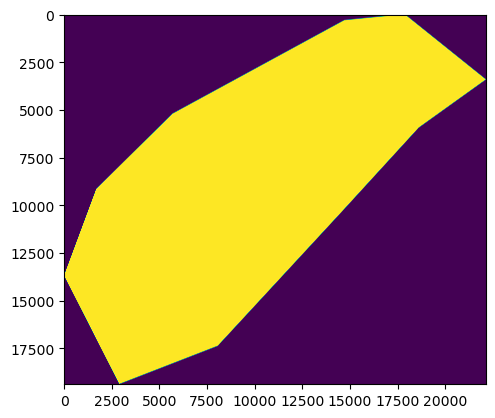

In [18]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

C:\Users\alextd\AppData\Local\Temp\3\ipykernel_30724\542924258.py:4: RuntimeWarning: overflow encountered in multiply
  class_prediction_ = class_prediction*mask
c:\ProgramData\miniconda3\envs\GIStools\Lib\site-packages\matplotlib\image.py:515: RuntimeWarning: overflow encountered in add
  A_resampled += a_min


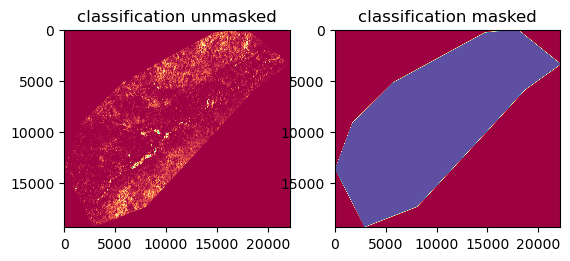

In [19]:
# mask classification an plot

class_prediction.astype(np.float16)
class_prediction_ = class_prediction*mask

plt.subplot(121)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(class_prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

### Section - Saving Classification Image to disk

In [20]:
cols = img.shape[1]
rows = img.shape[0]

class_prediction_.astype(np.float16)
driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(class_prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(classification_image))

C:\Users\alextd\AppData\Local\Temp\3\ipykernel_30724\1881186253.py:4: RuntimeWarning: overflow encountered in cast
  class_prediction_.astype(np.float16)


Image saved to: Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 9 Large\Ortho_classified.tif


### Section - Accuracy Assessment

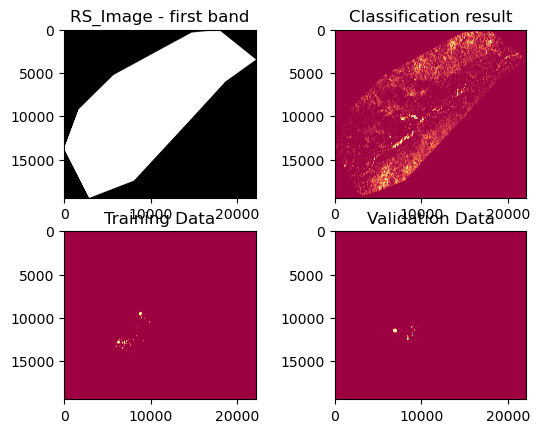

284540 validation pixels
validation data include 2 classes: [1 2]
Our X matrix is sized: (284540,)
Our y array is sized: (284540,)
col_0       1      2     All
row_0                       
1      222988   2577  225565
2       15578  43397   58975
All    238566  45974  284540
              precision    recall  f1-score   support

           1       0.93      0.99      0.96    225565
           2       0.94      0.74      0.83     58975

    accuracy                           0.94    284540
   macro avg       0.94      0.86      0.89    284540
weighted avg       0.94      0.94      0.93    284540

OAA = 93.61952625289942 %


In [21]:
# validation / accuracy assessment

# preparing ttxt file

print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# laod training data from shape file
shape_dataset_v = ogr.Open(validation)
shape_layer_v = shape_dataset_v.GetLayer()
mem_drv_v = gdal.GetDriverByName('MEM')
mem_raster_v = mem_drv_v.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())
mem_band_v = mem_raster_v.GetRasterBand(1)
mem_band_v.Fill(0)
mem_band_v.SetNoDataValue(0)

# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None

roi_v = mem_raster_v.ReadAsArray()



# vizualise
plt.subplot(221)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS_Image - first band')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('Classification result')


plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Spectral)
plt.title('Validation Data')

plt.show()


# Find how many non-zero entries we have -- i.e. how many validation data samples?
n_val = (roi_v > 0).sum()
print('{n} validation pixels'.format(n=n_val))
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

# What are our validation labels?
labels_v = np.unique(roi_v[roi_v > 0])
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v))
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))
# Subset the classification image with the validation image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_v = class_prediction[roi_v > 0]
y_v = roi_v[roi_v > 0]

print('Our X matrix is sized: {sz_v}'.format(sz_v=X_v.shape))
print('Our y array is sized: {sz_v}'.format(sz_v=y_v.shape))

# Cross-tabulate predictions
# confusion matrix
convolution_mat = pd.crosstab(y_v, X_v, margins=True)
print(convolution_mat)
print(convolution_mat, file=open(results_txt, "a"))
# if you want to save the confusion matrix as a CSV file:
#savename = 'C:\\save\\to\\folder\\conf_matrix_' + str(est) + '.csv'
#convolution_mat.to_csv(savename, sep=';', decimal = '.')

# information about precision, recall, f1_score, and support:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#sklearn.metrics.precision_recall_fscore_support
target_names = list()
for name in range(1,(labels.size)+1):
    target_names.append(str(name))
sum_mat = classification_report(y_v,X_v,target_names=target_names)
print(sum_mat)
print(sum_mat, file=open(results_txt, "a"))

# Overall Accuracy (OAA)
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100))
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100), file=open(results_txt, "a"))

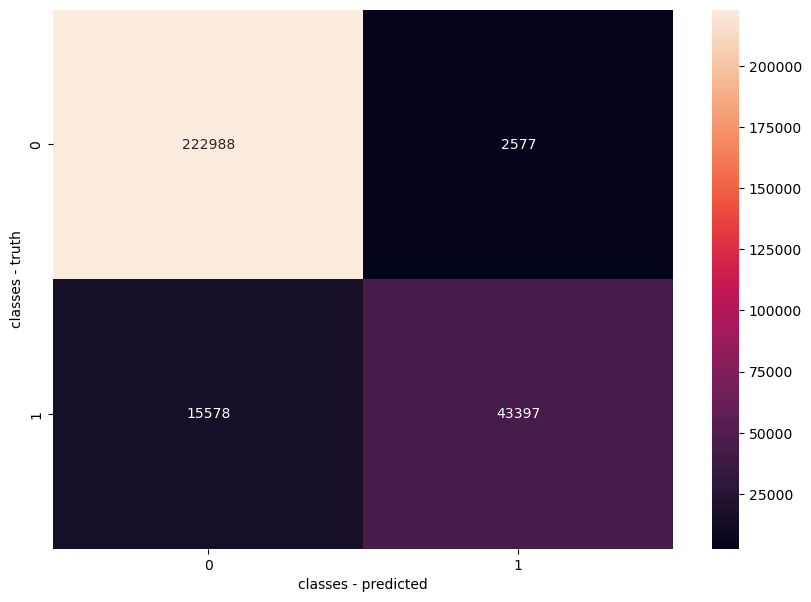

In [22]:
cm_val = confusion_matrix(roi_v[roi_v > 0],class_prediction[roi_v > 0])
plt.figure(figsize=(10,7))
sn.heatmap(cm_val, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()